In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing, svm, linear_model
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.utils import shuffle
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

data = pd.read_csv('./twitter-airline-sentiment/Tweets.csv')

In [84]:
y_raw = data['airline_sentiment']
# labeling data
le = preprocessing.LabelEncoder()
le.fit(y_raw)
le.classes_
y = le.transform(y_raw)

In [85]:
tweet = data['text']

In [86]:
# get word counts
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
from sklearn.base import BaseEstimator, ClassifierMixin, clone

class OneVsAllClassifier(BaseEstimator, ClassifierMixin):  
    """
    One-vs-all classifier
    We assume that the classes will be the integers 0,..,(n_classes-1).
    We assume that the estimator provided to the class, after fitting, has a "decision_function" that 
    returns the score for the positive class.
    """
    def __init__(self, estimator, n_classes):      
        """
        Constructed with the number of classes and an estimator (e.g. an
        SVM estimator from sklearn)
        @param estimator : binary base classifier used
        @param n_classes : number of classes
        """
        self.n_classes = n_classes 
        self.estimators = [clone(estimator) for _ in range(n_classes)]
        self.fitted = False

    def fit(self, X, y=None):
        """
        This should fit one classifier for each class.
        self.estimators[i] should be fit on class i vs rest
        @param X: array-like, shape = [n_samples,n_features], input data
        @param y: array-like, shape = [n_samples,] class labels
        @return returns self
        """
        #Your code goes here
        # design a binary label of y for each estimator
        for i in range(self.n_classes):
            y_bi = np.copy(y)
            y_bi[y_bi!=i]=-1
            self.estimators[i].fit(X,y_bi)
        self.fitted = True  
        return self   

    def decision_function(self, X):
        """
        Returns the score of each input for each class. Assumes
        that the given estimator also implements the decision_function method (which sklearn SVMs do), 
        and that fit has been called.
        @param X : array-like, shape = [n_samples, n_features] input data
        @return array-like, shape = [n_samples, n_classes]
        """
        if not self.fitted:
            raise RuntimeError("You must train classifer before predicting data.")

        if not hasattr(self.estimators[0], "decision_function"):
            raise AttributeError(
                "Base estimator doesn't have a decision_function attribute.")
        
        #Replace the following return statement with your code
        score = np.zeros([X.shape[0],self.n_classes])
        for i in range(self.n_classes):
            score[:,i] = self.estimators[i].decision_function(X)
        return score
    
    def predict(self, X):
        """
        Predict the class with the highest score.
        @param X: array-like, shape = [n_samples,n_features] input data
        @returns array-like, shape = [n_samples,] the predicted classes for each input
        """
        #Replace the following return statement with your code
        score = self.decision_function(X)
        prediction = np.zeros(X.shape[0])
        for i in range(X.shape[0]):
            prediction[i] = np.argmax(score[i])
        return prediction

 

In [6]:
def plotRocCurve(X_train, y_train, X_valid, y_valid, model, modelname):
    if modelname == 'RandomForest':
        y_score = model.fit(X_train, y_train).predict_proba(X_valid)
    else:
        y_score = model.fit(X_train, y_train).decision_function(X_valid)

    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_valid, y_score[:,i], pos_label=i)
        roc_auc[i] = auc(fpr[i], tpr[i])
    print(sum(roc_auc.values()) / len(roc_auc))

    label_list = ['negative', 'neutral', 'positive']
    fig = plt.figure(figsize = (6, 6))

    # Plot ROC curve
    for i in range(3):
        roc_auc = auc(fpr[i],tpr[i])
        plt.plot(fpr[i],tpr[i], label = label_list[i] + ' (AUC = %0.3f)' % roc_auc)
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0]) 
        plt.ylim([0.0, 1.0])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC_' + modelname)
        plt.legend(loc="lower right")

In [7]:
#Here we test the OneVsAllClassifier
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=0.2)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_onevsall.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_onevsall.predict(X_valid))

0.80806010929


array([[1722,  120,   47],
       [ 198,  320,   62],
       [  83,   52,  324]])

0.898614914152


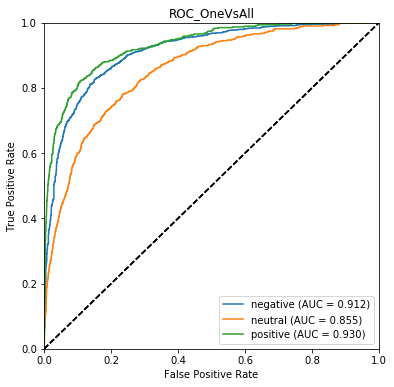

In [8]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_onevsall, 'OneVsAll')

In [9]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.02))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.80737704918


array([[1739,  112,   38],
       [ 212,  321,   47],
       [ 101,   54,  304]])

0.904695436214


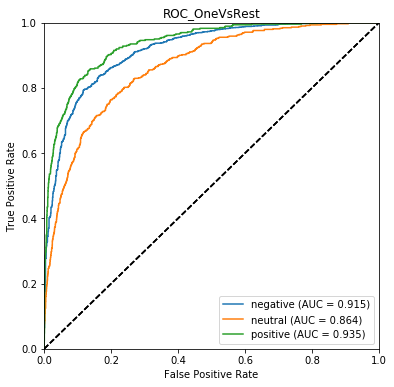

In [10]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [11]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.02))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.802254098361


array([[1714,  133,   42],
       [ 201,  335,   44],
       [  97,   62,  300]])

0.888295349678


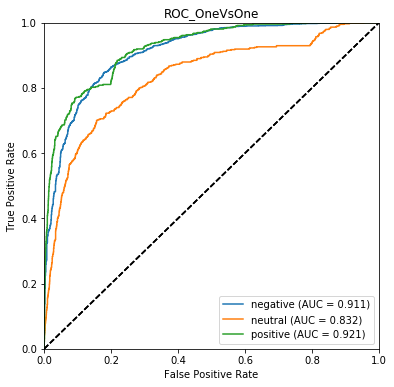

In [12]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [87]:
# gradient boosting
clf_gbm = GradientBoostingClassifier()
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

0.765368852459


array([[1774,   36,   39],
       [ 386,  183,   39],
       [ 154,   33,  284]])

0.838996030653


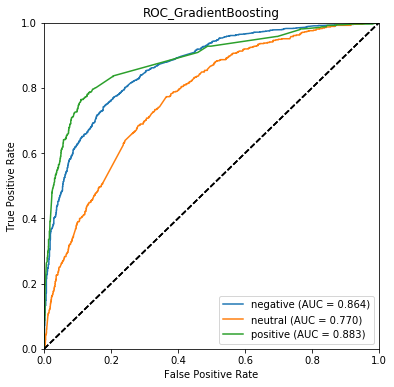

In [88]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [89]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

0.765027322404


array([[1784,   51,   14],
       [ 341,  231,   36],
       [ 197,   49,  225]])

0.891031720533


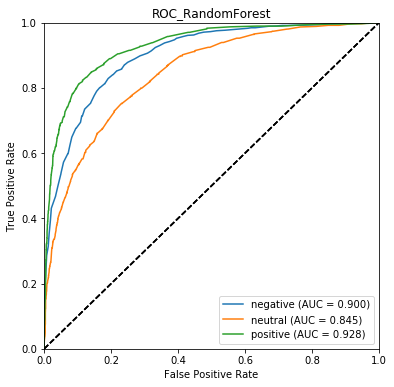

In [90]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [14]:
clf_log=linear_model.LogisticRegression(C=0.4)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.806352459016


array([[1722,  127,   40],
       [ 201,  329,   50],
       [  94,   55,  310]])

0.905520697802


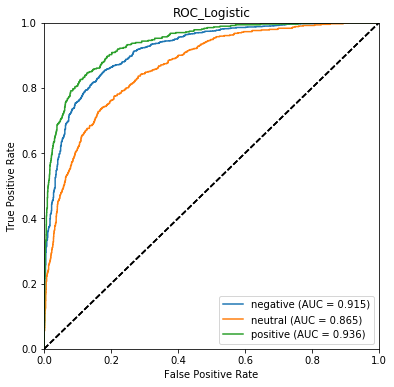

In [15]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

# Tf-Idf

In [91]:
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df=0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [17]:
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=0.85)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(tX_train,ty_train)

accuracy = np.mean(y_valid == clf_onevsall.predict(tX_valid))
print(accuracy)
    
metrics.confusion_matrix(ty_valid, clf_onevsall.predict(tX_valid))

0.812841530055


array([[1766,   84,   39],
       [ 231,  300,   49],
       [  98,   47,  314]])

0.900168096931


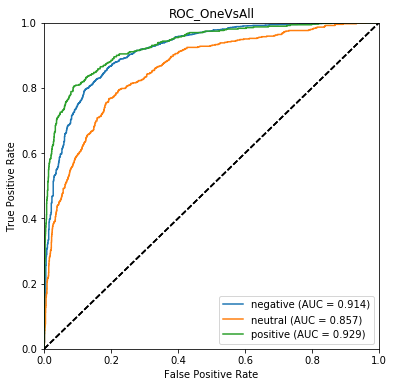

In [18]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_onevsall, 'OneVsAll')

In [19]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.02))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.80737704918


array([[1739,  112,   38],
       [ 212,  321,   47],
       [ 101,   54,  304]])

0.892332598847


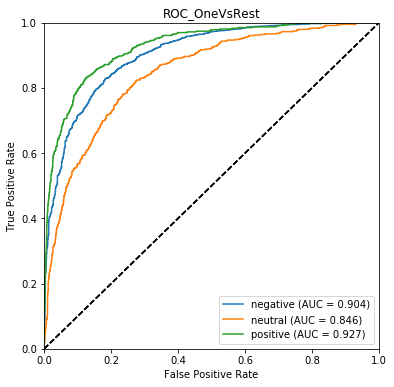

In [20]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [21]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.25))
clf_ovo.fit(tX_train, ty_train)

accuracy = np.mean(y_valid == clf_ovo.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_ovo.predict(tX_valid))

0.811133879781


array([[1756,  100,   33],
       [ 216,  321,   43],
       [ 102,   59,  298]])

0.893673536142


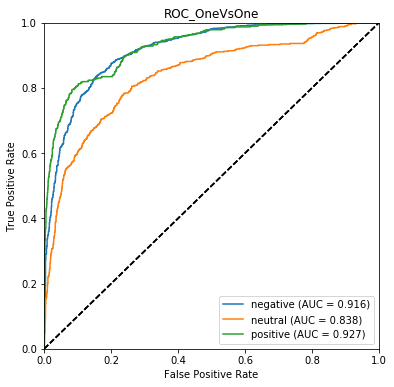

In [22]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

In [92]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(y_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))

0.776297814208


array([[1691,  103,   55],
       [ 273,  283,   52],
       [ 118,   54,  299]])

0.837611898531


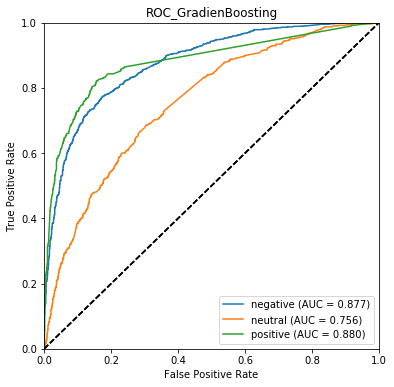

In [93]:
plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

In [94]:
clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(y_valid == clf_rfc.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))

0.760587431694


array([[1766,   65,   18],
       [ 333,  234,   41],
       [ 197,   47,  227]])

0.882558456679


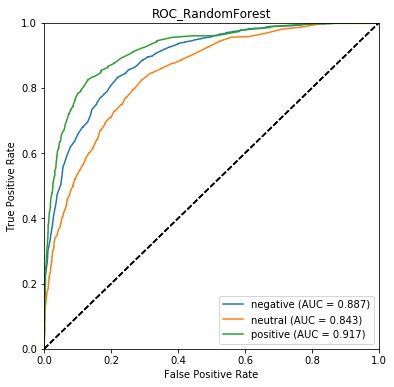

In [95]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [24]:
clf_log=linear_model.LogisticRegression(C=3.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(y_valid == clf_log.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))

0.813866120219


array([[1758,   97,   34],
       [ 218,  313,   49],
       [  96,   51,  312]])

0.905743506644


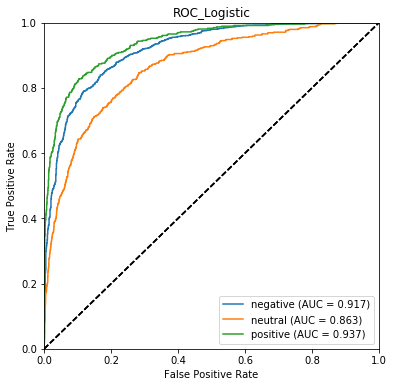

In [25]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

# Bi-grams

In [96]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
#Here we test the OneVsAllClassifier
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=0.05)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_onevsall.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_onevsall.predict(X_valid))

0.811133879781


array([[1722,  121,   46],
       [ 190,  336,   54],
       [  85,   57,  317]])

0.906320906152


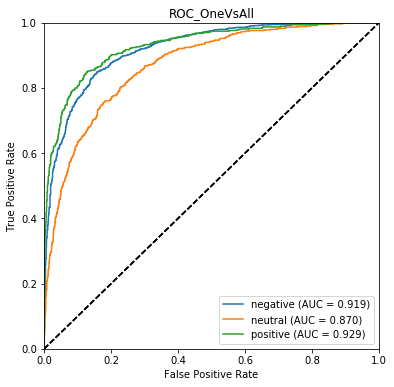

In [28]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_onevsall, 'OneVsAll')

In [29]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.02))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.811133879781


array([[1726,  122,   41],
       [ 187,  340,   53],
       [  92,   58,  309]])

0.911533619896


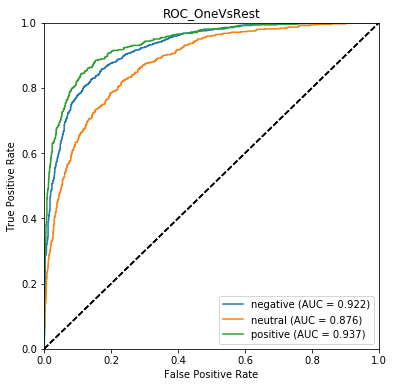

In [30]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [31]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.025))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.80737704918


array([[1710,  137,   42],
       [ 178,  354,   48],
       [  90,   69,  300]])

0.897020681132


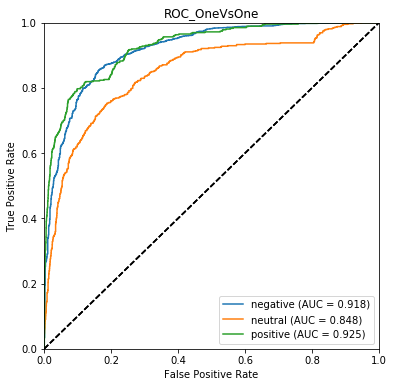

In [32]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

In [ ]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [ ]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

In [ ]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [34]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.811133879781


array([[1725,  125,   39],
       [ 182,  344,   54],
       [  93,   60,  306]])

0.911868212037


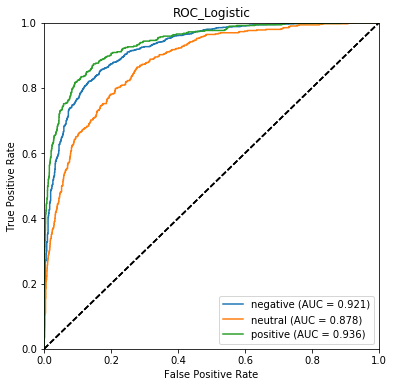

In [35]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

# Tri-grams

In [36]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [37]:
#Here we test the OneVsAllClassifier
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=0.05)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_onevsall.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_onevsall.predict(X_valid))

0.804986338798


array([[1700,  139,   50],
       [ 175,  344,   61],
       [  85,   61,  313]])

0.905315141767


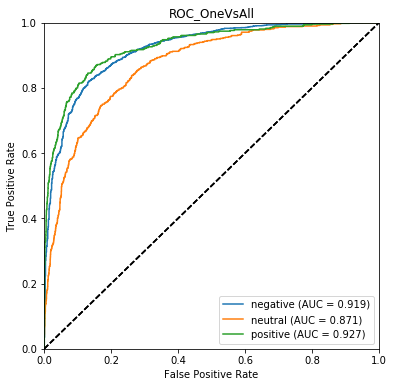

In [38]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_onevsall, 'OneVsAll')

In [39]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.02))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.813524590164


array([[1737,  112,   40],
       [ 195,  336,   49],
       [  90,   60,  309]])

0.911028530716


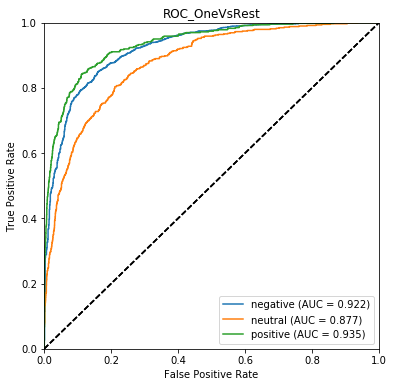

In [40]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [41]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.025))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.806693989071


array([[1712,  135,   42],
       [ 181,  352,   47],
       [  93,   68,  298]])

0.896016249774


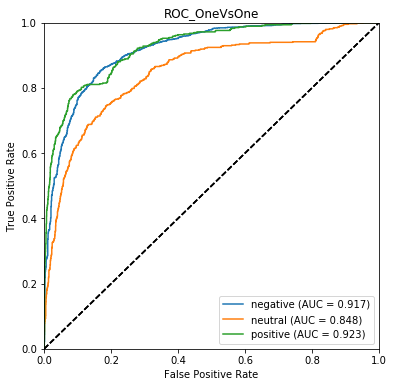

In [42]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

In [ ]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [ ]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

In [ ]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [43]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.808743169399


array([[1733,  117,   39],
       [ 195,  336,   49],
       [  99,   61,  299]])

0.911249761076


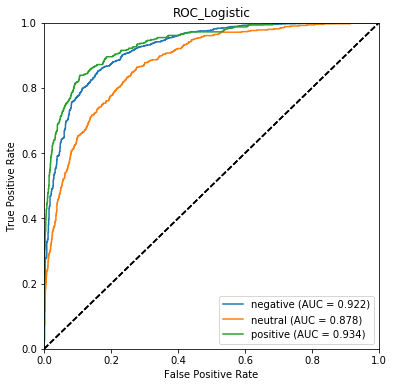

In [44]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

# Balanced data

In [45]:
data = shuffle(data,random_state=42)

index = list()
pos_count = 0
neg_count = 0 
neu_count = 0

for i in range(data.shape[0]):
    if data.iloc[i]["airline_sentiment"] == "positive":
        if pos_count < 1890:
            index.append(data.iloc[i].name)
        else:
            continue 
        pos_count += 1 
    elif data.iloc[i]["airline_sentiment"] == "negative":
        if neg_count < 1890:
            index.append(data.iloc[i].name)
        else:
            continue
        neg_count += 1 
    else:
        if neu_count <1890:
            index.append(data.iloc[i].name)
        else:
            continue
        neu_count += 1 
        
balanced_data = data.filter(index,axis = 0)

In [46]:
y_raw = balanced_data['airline_sentiment']
# labeling data
le = preprocessing.LabelEncoder()
le.fit(y_raw)
le.classes_
y = le.transform(y_raw)

In [47]:
tweet = balanced_data['text']

In [48]:
# get word counts
# unigram
count_vect = CountVectorizer()
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [49]:
#Here we test the OneVsAllClassifier
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=0.09)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_onevsall.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_onevsall.predict(X_valid))

0.756613756614


array([[306,  63,  32],
       [ 45, 264,  48],
       [ 25,  63, 288]])

0.889562250452


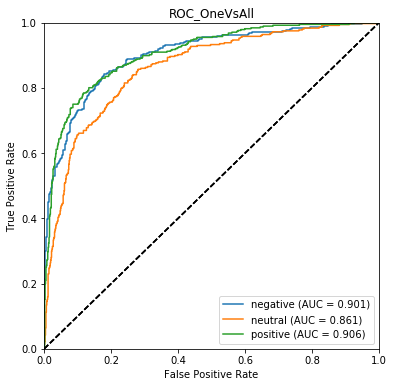

In [50]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_onevsall, 'OneVsAll')

In [51]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.05))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.749559082892


array([[303,  66,  32],
       [ 50, 260,  47],
       [ 22,  67, 287]])

0.894249567692


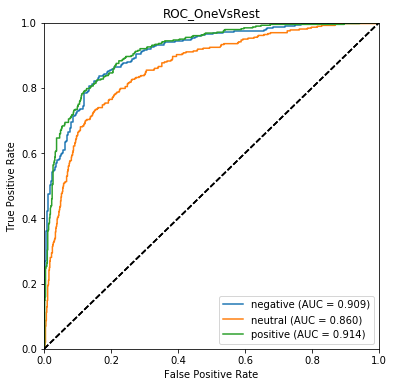

In [52]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [53]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.05))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.743386243386


array([[304,  68,  29],
       [ 48, 261,  48],
       [ 24,  74, 278]])

0.885930222444


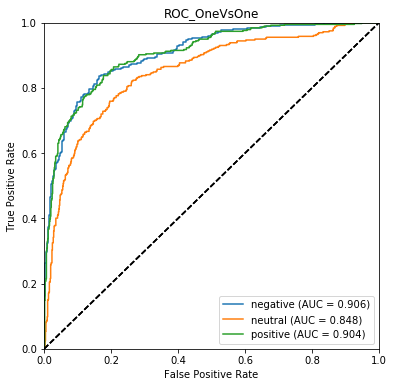

In [54]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

In [ ]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [ ]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

In [ ]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [55]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.751322751323


array([[305,  65,  31],
       [ 51, 260,  46],
       [ 25,  64, 287]])

0.894731977958


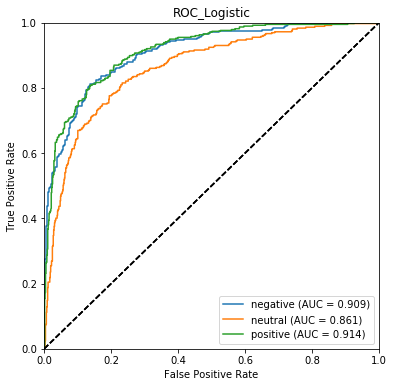

In [56]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [57]:
# tfidf
tweet_train, tweet_valid, ty_train, ty_valid = train_test_split(tweet, y, test_size=0.2, random_state=42)

vectorizer = TfidfVectorizer(min_df=5,max_df = 0.8,sublinear_tf=True,use_idf=True)
tX_train = vectorizer.fit_transform(tweet_train)
tX_valid = vectorizer.transform(tweet_valid)

In [58]:
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=0.4)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(tX_train,ty_train)

accuracy = np.mean(y_valid == clf_onevsall.predict(tX_valid))
print(accuracy)
    
metrics.confusion_matrix(ty_valid, clf_onevsall.predict(tX_valid))

0.765432098765


array([[313,  62,  26],
       [ 53, 266,  38],
       [ 34,  53, 289]])

0.894297338545


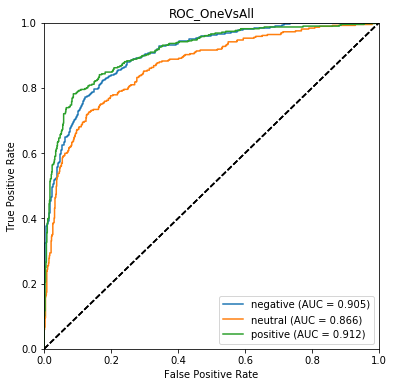

In [59]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_onevsall, 'OneVsAll')

In [60]:
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.1))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.750440917108


array([[306,  61,  34],
       [ 46, 261,  50],
       [ 28,  64, 284]])

0.897854435532


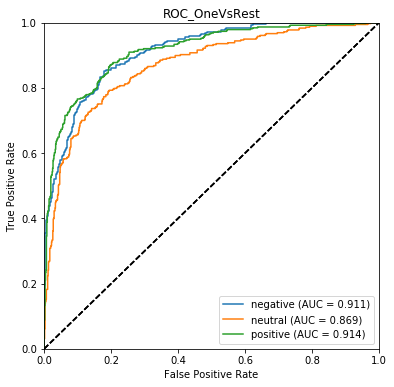

In [61]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovr, 'OneVsRest')

In [62]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.2))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.738095238095


array([[300,  71,  30],
       [ 47, 260,  50],
       [ 28,  71, 277]])

0.889530046105


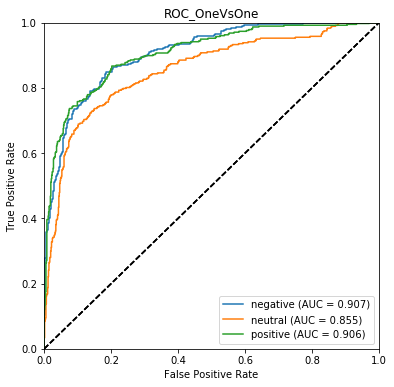

In [63]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_ovo, 'OneVsOne')

In [ ]:
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(tX_train,ty_train)

accuracy = np.mean(y_valid == clf_gbm.predict(tX_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_gbm.predict(tX_valid.toarray()))

In [ ]:
plotRocCurve(tX_train, ty_train, tX_valid.toarray(), ty_valid, clf_gbm, 'GradienBoosting')

In [ ]:
clf_rfc = RandomForestClassifier(n_estimators=100,random_state = 42)
clf_rfc.fit(tX_train,ty_train)

accuracy = np.mean(y_valid == clf_rfc.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_rfc.predict(tX_valid))

In [ ]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_rfc, 'RandomForest')

In [64]:
clf_log=linear_model.LogisticRegression(C=1.5)
clf_log.fit(tX_train,ty_train)

accuracy = np.mean(y_valid == clf_log.predict(tX_valid))
print(accuracy)

metrics.confusion_matrix(ty_valid, clf_log.predict(tX_valid))

0.753968253968


array([[306,  64,  31],
       [ 49, 264,  44],
       [ 34,  57, 285]])

0.897398721969


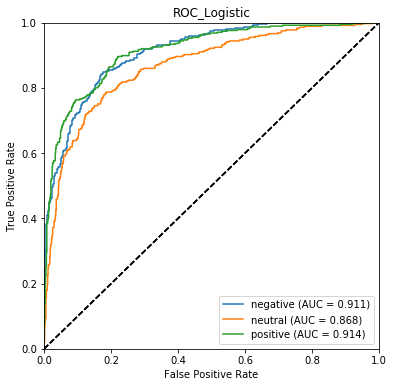

In [65]:
plotRocCurve(tX_train, ty_train, tX_valid, ty_valid, clf_log, 'Logistic')

In [66]:
# unigram and bi-grams
count_vect = CountVectorizer(ngram_range=(1,2))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [67]:
#Here we test the OneVsAllClassifier
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=0.05)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_onevsall.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_onevsall.predict(X_valid))

0.750440917108


array([[299,  73,  29],
       [ 43, 270,  44],
       [ 29,  65, 282]])

0.895369477095


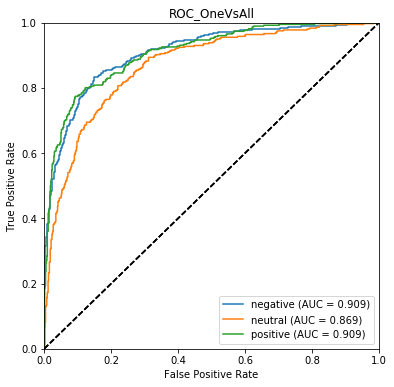

In [68]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_onevsall, 'OneVsAll')

In [69]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.03))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.750440917108


array([[304,  72,  25],
       [ 46, 268,  43],
       [ 25,  72, 279]])

0.9026466763


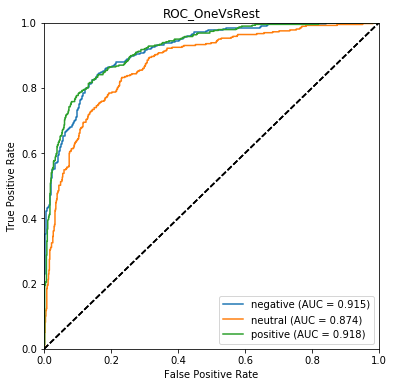

In [70]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [71]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.035))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.756613756614


array([[298,  75,  28],
       [ 42, 280,  35],
       [ 26,  70, 280]])

0.893991759638


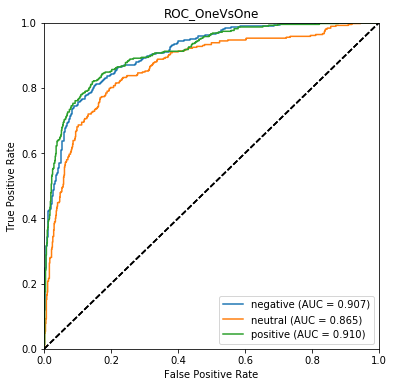

In [72]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

In [ ]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [ ]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

In [ ]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [73]:
clf_log=linear_model.LogisticRegression(C=0.5)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.756613756614


array([[309,  68,  24],
       [ 46, 270,  41],
       [ 26,  71, 279]])

0.902754813385


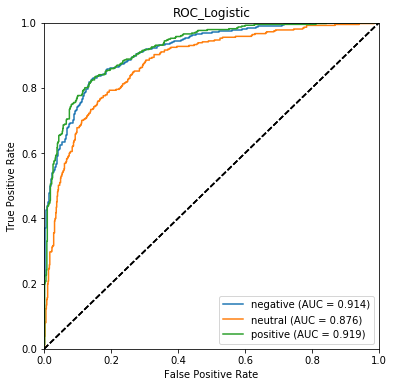

In [74]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')

In [75]:
# unigram, bi-grams & tri-grams
count_vect = CountVectorizer(ngram_range=(1,3))
X = count_vect.fit_transform(tweet)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [76]:
#Here we test the OneVsAllClassifier
svm_estimator = svm.LinearSVC(loss='hinge', fit_intercept=False, C=0.04)
clf_onevsall = OneVsAllClassifier(svm_estimator, n_classes=3)
clf_onevsall.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_onevsall.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_onevsall.predict(X_valid))

0.745149911817


array([[298,  74,  29],
       [ 46, 269,  42],
       [ 31,  67, 278]])

0.893493424475


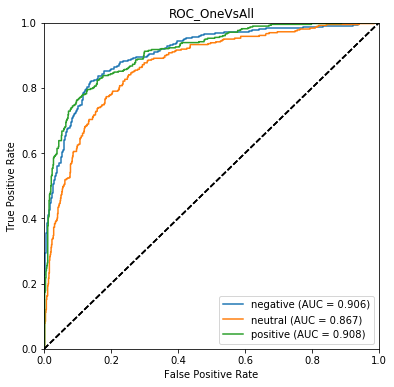

In [77]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_onevsall, 'OneVsAll')

In [78]:
# OneVsRestClassifier from sklearn
clf_ovr = OneVsRestClassifier(svm.LinearSVC(C=0.03))
clf_ovr.fit(X_train, y_train)
clf_ovr.predict(X_train)

accuracy = np.mean(y_valid == clf_ovr.predict(X_valid))
print(accuracy)
    
from sklearn import metrics
metrics.confusion_matrix(y_valid, clf_ovr.predict(X_valid))

0.76102292769


array([[306,  71,  24],
       [ 42, 276,  39],
       [ 25,  70, 281]])

0.901404483006


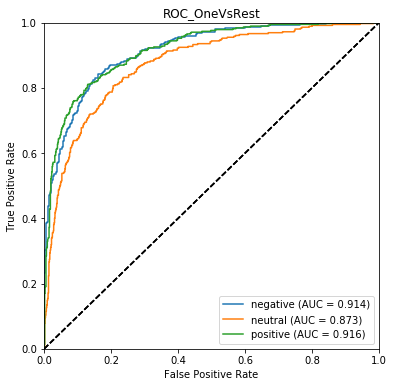

In [79]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovr, 'OneVsRest')

In [80]:
clf_ovo = OneVsOneClassifier(svm.LinearSVC(C=0.06))
clf_ovo.fit(X_train, y_train)

accuracy = np.mean(y_valid == clf_ovo.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_ovo.predict(X_valid))

0.754850088183


array([[296,  81,  24],
       [ 40, 279,  38],
       [ 25,  70, 281]])

0.89100607373


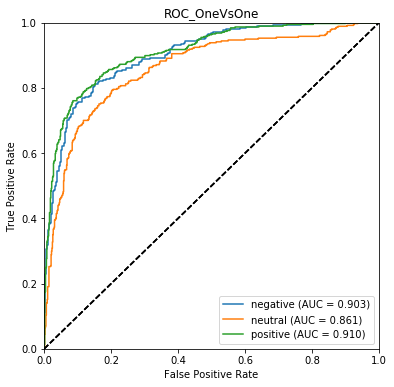

In [81]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_ovo, 'OneVsOne')

In [ ]:
# gradient boosting
clf_gbm = GradientBoostingClassifier(learning_rate=0.5)
clf_gbm.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_gbm.predict(X_valid.toarray()))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_gbm.predict(X_valid.toarray()))

In [ ]:
plotRocCurve(X_train, y_train, X_valid.toarray(), y_valid, clf_gbm, 'GradientBoosting')

In [ ]:
# random forest
clf_rfc = RandomForestClassifier(n_estimators=100,criterion='gini')
clf_rfc = clf_rfc.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_rfc.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_rfc.predict(X_valid))

In [ ]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_rfc, 'RandomForest')

In [82]:
clf_log=linear_model.LogisticRegression(C=0.85)
clf_log.fit(X_train,y_train)

accuracy = np.mean(y_valid == clf_log.predict(X_valid))
print(accuracy)

metrics.confusion_matrix(y_valid, clf_log.predict(X_valid))

0.753968253968


array([[306,  69,  26],
       [ 48, 269,  40],
       [ 28,  68, 280]])

0.901173106979


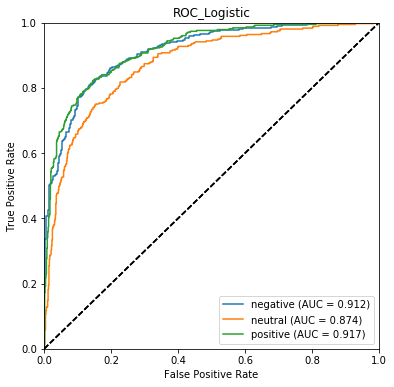

In [83]:
plotRocCurve(X_train, y_train, X_valid, y_valid, clf_log, 'Logistic')